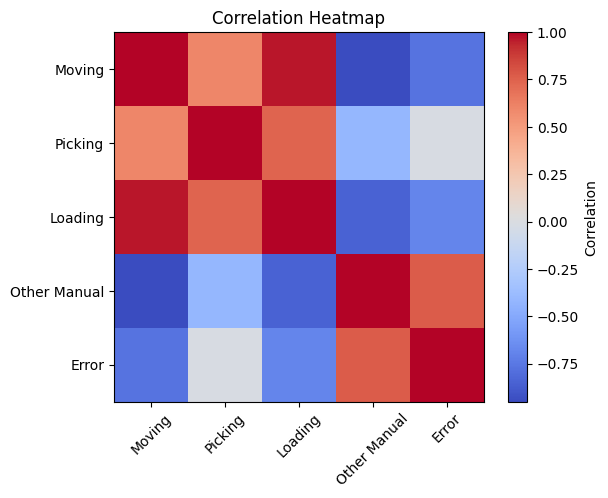

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Your data
data = {
    'Moving': [18.7, 16.4, 6.2, 3.1],
    'Picking': [9, 12.24, 6.48, 8.64],
    'Loading': [55.08, 52.2, 16.2, 19.98],
    'Other Manual': [10.7, 18.0, 37.2, 64.5],
    'Error': [4.02, 12.72, 12.75, 15.36]
}

df = pd.DataFrame(data)

# Calculate correlations
correlation_matrix = df.corr()
print(correlation_matrix)
# Plotting the heatmap using Matplotlib
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Correlation')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Correlation Heatmap')
plt.show()


In [160]:
import yaml
import simpy
import random
import numpy as np

class ManufLine:
    def __init__(self, env, n_machines, tasks, operators_assignement, tasks_assignement, config_file):

        """
        -- operators_assignement = [[1,2], [3], [4]] => 3 operators: first one operates on machine 1 and machine 2,
            second one operates on machine 3 and third one operates on machine 4.

        -- tasks_assignement = [1, 1, 2, 3, 3, 4, 4, 4 ....]

         """
        
        with open(config_file, 'r') as stream:
            config = yaml.safe_load(stream)

        self.env = env
        self.parts_done = 0
        self.sim_time = eval(config['sim_time'])
        self.breakdowns = config['breakdowns']['enabled'] 
        
        machine_indices = [[] for _ in range(n_machines)]
            
        for index, machine in enumerate(tasks_assignement):
                machine_indices[machine - 1].append(index)
            
        
        if n_machines != max(tasks_assignement):
            raise ValueError('No match between assignement of tasks and number of machines.')

        if n_machines != max(max(operators_assignement)):
            raise ValueError('No match between assignement of operators and number of machines.')
        
        self.list_machines = []
        self.list_operators = [Operator(operators_assignement[i]) for i in range(len(operators_assignement))]

        previous_machine = None
        for i in range(n_machines):
           
            assigned_tasks = list(np.array(tasks)[machine_indices[i]])
            
            first, last = False, False
            if i == n_machines-1:
                last = True
            if i == 0:
                first = True
            assigned_operator_index = self.get_index_of_item([operator.assigned_machines for operator in self.list_operators], i+1)
            
            machine = Machine(env, "M"+str(i+1), assigned_tasks, 1000, operator=self.list_operators[assigned_operator_index], previous_machine=previous_machine, first=first, last=last, breakdowns=self.breakdowns, mean_time_to_failure=eval(config['breakdowns']['mttf']))
            
            previous_machine = machine
            self.list_machines.append(machine)


    def get_index_of_item(self, list_of_lists, item):
        for index, sublist in enumerate(list_of_lists):
            if item in sublist:
                return index
        return None  
    
    def generate(self):
        return self.env
    
    def get_results(self):
        idle_times = []
        CTs = []
        
        for i, machine in enumerate(self.list_machines):
            idle_times_machine = []
            ct_machine = []
            for entry, exit in zip(machine.entry_times, machine.exit_times):
                idle_times_machine.append(exit-entry)
            idle_times.append(np.mean(idle_times_machine))

            for entry, finished in zip(machine.entry_times, machine.finished_times):
                ct_machine.append(finished-entry)
            CTs.append(np.mean(ct_machine))

        print("Machine Idle Times = ", idle_times)
        print("Downtime of Machines = ", [1000*machine.n_breakdowns for machine in self.list_machines])
        print("Parts done --", self.list_machines[-1].buffer_out.level)
        print("Cycle Time --", self.sim_time/self.list_machines[-1].buffer_out.level)
    
    def run(self):
        self.generate().run(until=self.sim_time)

class Machine:
    def __init__(self, env, machine_id, assigned_tasks, buffer_capacity, operator=None, previous_machine = None, init=0, first = False, last=False, breakdowns=True, mean_time_to_failure=3600*24*7):
        self.mt = 0
        self.ID = machine_id
        self.env = env
        self.entry_times = []  
        self.exit_times = []   # List to store exit times of parts
        self.finished_times = []
        self.n_breakdowns = 0
        if first:
            init = float('inf')
        self.buffer_in = simpy.Container(env, capacity=float('inf'), init=init)
        self.buffer_out = simpy.Container(env, capacity=float('inf'), init=0)
        self.MTTF = mean_time_to_failure #Mean time to failure in seconds
        self.assigned_tasks = assigned_tasks
        
        self.last = last
        self.first = first
        self.broken = False
        self.breakdowns = breakdowns
       
        self.process = self.env.process(self.machine_process())
        env.process(self.break_down())
        print("Machine " + self.ID + " buffer -- ", self.buffer_in.level)
        #self.env.process(self.manual_process())
        if previous_machine:
            self.buffer_in = previous_machine.buffer_out
    
    def time_to_failure(self):
        """Return time until next failure for a machine."""
        return random.expovariate(1/self.MTTF)

    def machine_process(self):
        while True:
            done_in = np.sum([task.machine_time for task in self.assigned_tasks])
            start = self.env.now
            while done_in> 0:
                try:
                    entry_time = self.env.now
                    self.entry_times.append(entry_time)
                    # Start making a new part
                    #yield self.loaded
                    yield self.buffer_in.get(1)
                    # Record the entry time
                    #exit_time = self.env.now
                    self.exit_times.append(self.env.now)
                    yield self.env.timeout(done_in)
                    done_in = 0
                    
                except simpy.Interrupt:
                    self.broken = True
                    done_in -= self.env.now - start
                    yield self.env.timeout(1000)
                    self.broken = False
            # Record the exit time
            finish_time = self.env.now
            self.finished_times.append(finish_time)
            yield self.buffer_out.put(1)
            # Allow other processes to run
            yield self.env.timeout(0)

    def break_down(self):
        """Break the machine every now and then."""
        if self.breakdowns:
            while True:
                yield self.env.timeout(self.time_to_failure())
                if not self.broken:
                    #print("Machine " + self.ID + " Has broken-down ")
                    self.n_breakdowns += 1
                    # Only break the machine if it is currently working.
                    self.process.interrupt()      

    # def manual_process(self):
    #     while True:
    #         print("Operator waiting -- ")
    #         yield self.free
    #         print("Operator starts -- ")
    #         processing_time = np.sum([task.manual_time for task in self.assigned_tasks])
    #         yield self.env.timeout(processing_time)
    #         self.loaded.succeed()  # Signal that the machine is loaded
    #         print("Operator finished")

class Task:
    def __init__(self, ID, machine_time, manual_time):
        self.ID = ID
        self.machine_time = machine_time
        self.manual_time = manual_time

class Operator:
    def __init__(self, assigned_machines):
        self.assigned_machines = assigned_machines
        self.wc = 0

In [2]:
def find_closest_index(lst, target):
    return min(range(len(lst)), key=lambda i: abs(lst[i] - target))

# Example usage
my_list = [1, 5, 7, 15, 20]
target_value = 12

closest_index = find_closest_index(my_list, target_value)

print(f"The index of the closest element to {target_value} is {closest_index}")


The index of the closest element to 12 is 3


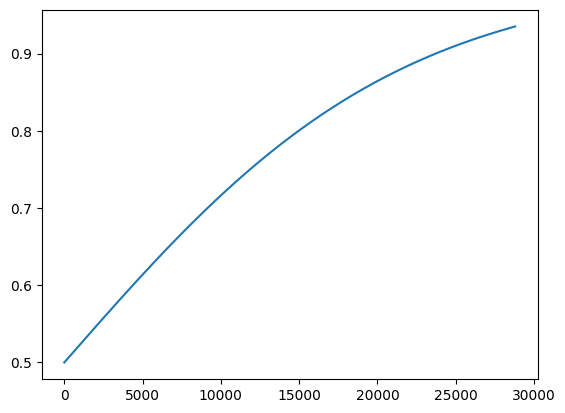

In [7]:
import matplotlib.pyplot as plt
import numpy as np
def sigmoid(x):
    """
    Sigmoid function.

    Parameters:
    - x (float): Input value.

    Returns:
    - float: Sigmoid of x.
    """
    return 1 / (1 + np.exp(-x/(4*3600)))

y= []
x = []
for i in range(3600*8):
    x.append(i)
    y.append(sigmoid(i))
plt.plot(x, y)

In [8]:
from collections import deque

# Create a deque with a maximum length of 5
d = deque(maxlen=5)

# Add some elements to the deque
d.extend([1, 2, 3, 4, 2, 5])

# Check if the deque is full
is_full = len(d) == d.maxlen

print(f"Is the deque full? {is_full}")

Is the deque full? True


In [161]:
import random
import simpy

env = simpy.Environment()

## generate random tasks:
def generate_random_tasks(num_tasks):
    tasks = []
    for task_id in range(1, num_tasks + 1):
        machine_time = random.randint(1, 50)  
        #manual_time = random.randint(1, 50)  
        manual_time = 0
        task = Task(task_id, machine_time, manual_time)
        tasks.append(task)
    return tasks

def known_tasks(list):
    tasks = []
    for task_id, task_mt in enumerate(list):
        machine_time = task_mt  
        manual_time = 0 
        task = Task(task_id, machine_time, manual_time)
        tasks.append(task)
    return tasks

#tasks = generate_random_tasks(5)
tasks = known_tasks([31, 18, 42, 36, 20])
print([t.machine_time for t in tasks])
config_file = 'config.yaml'
task_assignement = [1, 1, 2, 2, 3]

assembly_line = ManufLine(env, 3, tasks, [[1,2], [3]], task_assignement, config_file=config_file)

assembly_line.run()
assembly_line.get_results()

[31, 18, 42, 36, 20]
Machine M1 buffer --  inf
Machine M2 buffer --  0
Machine M3 buffer --  0
Machine Idle Times =  [0.0, 0.0001212907314078636, 1079.7842942742889]
Downtime of Machines =  [23000, 27000, 24000]
Parts done -- 403955
Cycle Time -- 78.0681016449852


### Other tests

In [63]:
import yaml
import simpy
import random
import numpy as np
from scipy.stats import weibull_min
import matplotlib.pyplot as plt

class ManufLine:
    def __init__(self, env, n_machines, tasks, operators_assignement, tasks_assignement, config_file):

        """
        -- operators_assignement = [[1,2], [3], [4]] => 3 operators: first one operates on machine 1 and machine 2,
            second one operates on machine 3 and third one operates on machine 4.

        -- tasks_assignement = [1, 1, 2, 3, 3, 4, 4, 4 ....]

         """
        
        with open(config_file, 'r') as stream:
            config = yaml.safe_load(stream)

        self.env = env
        self.parts_done = 0
        self.sim_time = eval(config['sim_time'])
        self.breakdowns = config['breakdowns']['enabled'] 
        self.buffers_config = config['buffers']
        
        
        machine_indices = [[] for _ in range(n_machines)]
            
        for index, machine in enumerate(tasks_assignement):
                machine_indices[machine - 1].append(index)
            
        
        if n_machines != max(tasks_assignement):
            raise ValueError('No match between assignement of tasks and number of machines.')

        if n_machines != max(max(operators_assignement)):
            raise ValueError('No match between assignement of operators and number of machines.')
        
        self.list_machines = []
        self.list_operators = [Operator(operators_assignement[i]) for i in range(len(operators_assignement))]

        previous_machine = None
        for i in range(n_machines):
           
            assigned_tasks = list(np.array(tasks)[machine_indices[i]])
            
            first, last = False, False
            if i == n_machines-1:
                last = True
            if i == 0:
                first = True
            assigned_operator_index = self.get_index_of_item([operator.assigned_machines for operator in self.list_operators], i+1)
            
            machine = Machine(env, "M"+str(i+1), assigned_tasks, self.buffers_config, operator=self.list_operators[assigned_operator_index], previous_machine=previous_machine, first=first, last=last, breakdowns=self.breakdowns, mean_time_to_failure=eval(config['breakdowns']['mttf']), hazard_delays=config['hazard_delays']['enabled'])
            
            previous_machine = machine
            self.list_machines.append(machine)


    def get_index_of_item(self, list_of_lists, item):
        for index, sublist in enumerate(list_of_lists):
            if item in sublist:
                return index
        return None  
    
    def generate(self):
        return self.env
    
    def get_results(self):
        idle_times = []
        CTs = []
        
        for i, machine in enumerate(self.list_machines):
            idle_times_machine = []
            ct_machine = []
            for entry, exit in zip(machine.entry_times, machine.exit_times):
                idle_times_machine.append(exit-entry)
            idle_times.append(np.mean(idle_times_machine))

            for entry, finished in zip(machine.entry_times, machine.finished_times):
                ct_machine.append(finished-entry)
            CTs.append(np.mean(ct_machine))

        print("Machine Idle Times = ", idle_times)
        print("Downtime of Machines = ", [1000*machine.n_breakdowns for machine in self.list_machines])
        print("Parts done --", self.list_machines[-1].buffer_out.level)
        print("Cycle Time --", self.sim_time/self.list_machines[-1].buffer_out.level)

    def get_track(self):
        for i, machine in enumerate(self.list_machines):
            if not machine.last:
                plt.plot([t[0] for t in machine.buffer_tracks], [t[1] for t in machine.buffer_tracks], label='Buffer M '+str(i+1))
                plt.legend()
            else:
                machine_last = machine
        plt.show()
        # plt.plot([t[0] for t in machine_last.buffer_tracks], [t[1] for t in machine_last.buffer_tracks], label='Final Buffer')
        # plt.show()


    def run(self):
        print(f"Current simulation time at the start: {self.env.now}")
        self.generate()
        env.run(until=self.sim_time)
        print(f"Current simulation time at the end: {self.env.now}")

class Machine:
    def __init__(self, env, machine_id, assigned_tasks, buffers_config, operator=None, previous_machine = None, first = False, last=False, breakdowns=True, mean_time_to_failure=3600*24*7, hazard_delays=False):
        self.mt = 0
        self.ID = machine_id
        self.env = env
        self.entry_times = []  # List to store entry times of parts
        self.exit_times = []   # List to store exit times of parts
        self.finished_times = []
        self.n_breakdowns = 0
        self.buffer_tracks = []
        self.parts_done = 0
        if first:
            self.buffer_in = simpy.Container(env, capacity=float('inf'), init=float(buffers_config["init_first_buffer"]))
            self.buffer_out = simpy.Container(env, capacity=float(buffers_config["capacity"]), init=0)
        
        if last:
            self.buffer_in = simpy.Container(env, capacity=float(buffers_config["capacity"]), init=0)
            self.buffer_out = simpy.Container(env, capacity=float(buffers_config["capacity_final_buffer"]), init=0)

        
        if not first and not last:
            self.buffer_in = simpy.Container(env, capacity=float(buffers_config["capacity"]), init=0)
            self.buffer_out = simpy.Container(env, capacity=float(buffers_config["capacity"]), init=0)
        self.MTTF = mean_time_to_failure #Mean time to failure in seconds
        self.assigned_tasks = assigned_tasks
        
        self.operator = operator  # Assign the operator to the machine

        # Events to signal when the machine is loaded and when the operator is free
        self.loaded = env.event()
        

        self.last = last
        self.first = first
        self.broken = False
        self.breakdowns = breakdowns
        self.hazard_delays = 1 if hazard_delays else 0
       
        self.process = self.env.process(self.machine_process())
        env.process(self.break_down())
        print("Machine " + self.ID + " buffer -- ", self.buffer_in.level)
        #self.env.process(self.manual_process())
        if previous_machine:
            self.buffer_in = previous_machine.buffer_out
    
    def time_to_failure(self):
        """Return time until next failure for a machine."""
        return random.expovariate(1/self.MTTF)

    def machine_process(self):
        bias_shape = 2  # shape parameter
        bias_scale = 1  # scale parameter
        num_samples = len(self.assigned_tasks)
        while True:
            
            print("delays weibull = ", self.hazard_delays*np.mean(weibull_min.rvs(bias_shape, scale=bias_scale, size=num_samples)))
            done_in = np.sum([task.machine_time+task.manual_time for task in self.assigned_tasks]) + self.hazard_delays*np.mean(weibull_min.rvs(bias_shape, scale=bias_scale, size=num_samples))
            
            start = self.env.now
            self.buffer_tracks.append((self.env.now, self.buffer_out.level))
            
    
            while done_in > 0:
                try:
                    self.entry_times.append(self.env.now)
                    yield self.buffer_in.get(1)
                    self.exit_times.append(self.env.now)
                    yield self.env.timeout(done_in)
                    finish_time = self.env.now
                    while self.buffer_out.level == self.buffer_out.capacity:
                        yield self.env.timeout(1)
                    self.finished_times.append(finish_time)
                    self.loaded = False
                    yield self.buffer_out.put(1)
                    done_in = 0
                except simpy.Interrupt:
                    self.broken = True
                    done_in -= self.env.now - start
                    yield self.env.timeout(1000)
                    self.broken = False
           
            self.parts_done = self.parts_done +1
            yield self.env.timeout(0)

    def break_down(self):
        """Break the machine every now and then."""
        if self.breakdowns:
            while True:
                yield self.env.timeout(self.time_to_failure())
                if not self.broken:
                    self.n_breakdowns += 1
                    self.process.interrupt()      



class Task:
    def __init__(self, ID, machine_time, manual_time):
        self.ID = ID
        self.machine_time = machine_time
        self.manual_time = manual_time

class Operator:
    def __init__(self, assigned_machines):
        self.assigned_machines = assigned_machines
        self.wc = 0
        self.free = True

In [81]:
import numpy as np
from scipy.stats import weibull_min
from scipy.special import gamma

# Define parameters
alpha = 0.5 # Shape parameter
beta = 1.0   # Scale parameter
num_samples = 4  # Sample size

# Calculate mean
mean_value = beta * gamma(1 + 1/alpha)

# Calculate standard error of the mean (SEM)
sem = np.sqrt((beta * gamma(1 + 2/alpha) - (beta * gamma(1 + 1/alpha))**2) / num_samples)

# Assuming a normal distribution for the confidence interval
confidence_level = 0.95
z_score = 1.96  # For a 95% confidence interval

# Calculate confidence interval
lower_bound = mean_value - z_score * sem
upper_bound = mean_value + z_score * sem

print("Mean:", mean_value)
print(f"Confidence Interval ({confidence_level * 100}%): [{lower_bound}, {upper_bound}]")
print(np.mean(weibull_min.rvs(alpha, scale=beta, size=num_samples)))

Mean: 2.0
Confidence Interval (95.0%): [-2.3826932358995876, 6.382693235899588]


[14, 17, 17, 14, 2, 2, 14, 1, 9, 1, 7, 8, 7, 13, 10, 2, 5, 24, 2, 5, 11, 2, 24, 5, 5, 2, 2, 17, 14, 11, 2, 8, 4, 1, 2]
35
Machine M1 buffer --  inf
Machine M2 buffer --  0
Machine M3 buffer --  0
Machine M4 buffer --  0
Current simulation time at the start: 0
delays weibull =  0.9181119743456883
delays weibull =  1.205995876714337
delays weibull =  0.7245840797547317
delays weibull =  0.9906764329856169
delays weibull =  0.9011281803253535
delays weibull =  0.9977104075844511
delays weibull =  0.6687754713694576
delays weibull =  0.9772672409880372
delays weibull =  0.9041452368937872
delays weibull =  0.666166416034174
delays weibull =  1.2147951141632978
delays weibull =  0.878440004873505
delays weibull =  0.7621568043197878
delays weibull =  0.9176445183863662
delays weibull =  0.8162738525432758
delays weibull =  0.5666129788687355
delays weibull =  0.814044132447786
delays weibull =  1.1256704927613521
delays weibull =  1.207141618347267
delays weibull =  1.1155346279670377
delay

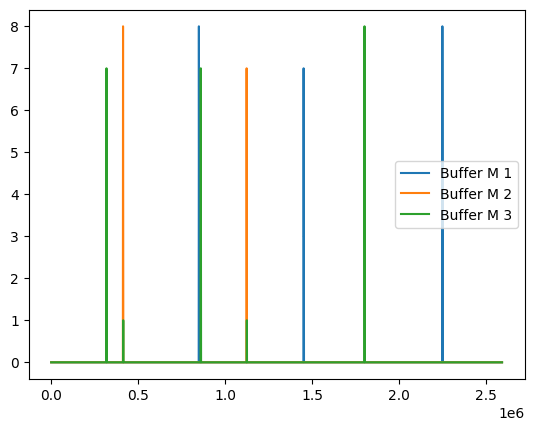

In [65]:
import random
import simpy
import pandas as pd

env = simpy.Environment()


def generate_random_tasks(num_tasks):
    tasks = []
    for task_id in range(1, num_tasks + 1):
        machine_time = random.randint(1, 50)  # Adjust the range as needed
        #manual_time = random.randint(1, 50)  # Adjust the range as needed
        manual_time = 0
        task = Task(task_id, machine_time, manual_time)
        tasks.append(task)
    return tasks

def known_tasks(list):
    tasks = []
    for task_id, task_mt in enumerate(list):
        machine_time = task_mt  # Adjust the range as needed
        manual_time = 3 # Adjust the range as needed
        task = Task(task_id, machine_time, manual_time)
        tasks.append(task)
    return tasks

#tasks = generate_random_tasks(5)
tasks = known_tasks([31, 18, 42, 36, 20])
df_tasks = pd.read_xml('./workplan_TestIsostatique_modified.xml', xpath=".//weldings//welding")
tasks = known_tasks(df_tasks["cycleTime"].astype(int).tolist())

print([t.machine_time for t in tasks])
config_file = 'config.yaml'

task_assignement = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3,  3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4]
print(len(task_assignement))
assembly_line = ManufLine(env, 4, tasks, [[1], [2], [3, 4]], task_assignement, config_file=config_file)
assembly_line.run()
assembly_line.get_results()
assembly_line.get_track()

In [51]:
for i in range(len(assembly_line.list_machines)):
    print(assembly_line.list_machines[i].parts_done)

19755
19754
19752
19747


In [52]:
assembly_line.list_machines[1].buffer_in.capacity

200.0

Sim Vizualisation

In [6]:
import tkinter as tk
import threading

class Visualization(tk.Tk):
    def __init__(self, manuf_line):
        super().__init__()
        self.manuf_line = manuf_line

        self.canvas = tk.Canvas(self, width=800, height=400)
        self.canvas.pack()

        self.machine_rects = []
        self.buffer_rects = []

        self.create_machines_and_buffers()

    def create_machines_and_buffers(self):
        machine_width = 60
        machine_height = 30
        buffer_width = 20
        buffer_height = 20
        spacing = 100

        for i, machine in enumerate(self.manuf_line.list_machines):
            x = i * spacing + 50
            y = 100

            machine_rect = self.canvas.create_rectangle(x, y, x + machine_width, y + machine_height, fill="green")
            self.machine_rects.append(machine_rect)

            buffer_rect = self.canvas.create_rectangle(x + machine_width + 10, y, x + machine_width + 10 + buffer_width, y + buffer_height, fill="blue")
            self.buffer_rects.append(buffer_rect)

    def update_visualization(self):
        for i, machine in enumerate(self.manuf_line.list_machines):
            machine_rect = self.machine_rects[i]
            buffer_rect = self.buffer_rects[i]

            # Update machine color based on its status
            if machine.loaded:
                self.canvas.itemconfig(machine_rect, fill="red")
            else:
                self.canvas.itemconfig(machine_rect, fill="green")

            # Update buffer color based on its level
            buffer_level = machine.buffer_in.level
            buffer_color = "blue" if buffer_level > 0 else "white"
            self.canvas.itemconfig(buffer_rect, fill=buffer_color)

        self.after(100, self.update_visualization)


env = simpy.Environment()
df_tasks = pd.read_xml('./workplan_TestIsostatique_modified.xml', xpath=".//weldings//welding")
tasks = known_tasks(df_tasks["cycleTime"].astype(int).tolist())

print([t.machine_time for t in tasks])
config_file = 'config.yaml'
task_assignement = [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,  3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4]
print(len(task_assignement))
assembly_line = ManufLine(env, 4, tasks, [[1], [2], [3, 4]], task_assignement, config_file=config_file)
assembly_line.run()
assembly_line.get_results()

manuf_line = ManufLine(env, 4, tasks, [[1], [2], [3, 4]], task_assignement, config_file=config_file)

simulation_thread = threading.Thread(target=manuf_line.run, args=(env, 4, tasks, [[1], [2], [3, 4]], task_assignement, config_file), daemon=True)
simulation_thread.start()

visualization = Visualization(manuf_line=None)
visualization.run_visualization()


# visualization = Visualization(manuf_line)
# visualization.update_visualization()
# visualization.after(0, assembly_line.run)  # Schedule the initial run
visualization.mainloop()

[14, 17, 17, 14, 2, 2, 14, 1, 9, 1, 7, 8, 7, 13, 10, 2, 5, 24, 2, 5, 11, 2, 24, 5, 5, 2, 2, 17, 14, 11, 2, 8, 4, 1, 2]
35
Machine M1 buffer --  inf
Machine M2 buffer --  0
Machine M3 buffer --  0
Machine M4 buffer --  0
Current simulation time at the start: 0
Current simulation time at the end: 31536000


Exception in thread Thread-5:
Traceback (most recent call last):
  File "c:\Users\Nasio\miniconda3\envs\assemblyenv\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "c:\Users\Nasio\miniconda3\envs\assemblyenv\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: run() takes 1 positional argument but 7 were given


Machine Idle Times =  [0.0, 334.0505641393651, 0.0007083177833461542, 580.0472493174636]
Downtime of Machines =  [21000, 16000, 28000, 20000]
Parts done -- 262552
Cycle Time -- 120.1133489746793
Machine M1 buffer --  inf
Machine M2 buffer --  0
Machine M3 buffer --  0
Machine M4 buffer --  0


AttributeError: 'NoneType' object has no attribute 'list_machines'

Machine M1 buffer --  inf
Machine M2 buffer --  0
Machine M3 buffer --  0
Machine M4 buffer --  0
Machine Idle Times =  [0.0, 676.4325505105317, 0.0007081209287805473, 408.1658247884682]
Downtime of Machines =  [25000, 33000, 18000, 24000]
Parts done -- 262627
Cycle Time -- 120.07904747036672

## Capacity Lines

In [ ]:
class CapacityLine():
    def __init__(self, env, n_machines, n_operators, tasks):
        self.n_machines = n_machines
        self.n_operators = n_operators
        self.tasks = tasks
        self.machines = [simpy.Resource(env, capacity=1) for _ in range(n_machines)]